# Deep Learning Black Scholes using TensorFlow
The goal of this case study is to perform derivative pricing from a machine learning standpoint and use supervised regression-based model to learn the Black-Scholes option pricing model from simulated data.


<a id='0'></a>
# 1. Problem Definition

In the supervised regression framework used for this case study, the derivative pricing
problem is defined in the regression framework, where the predicted variable is the
pricing of the option, and the predictor variables are the market data that are used as
inputs to the Black-Scholes option pricing model

Options have been used in finance as means to hedge risk in a nonlinear manner. They are are also used by speculators in order to take leveraged bets in the financial markets. Historically, people have used the Black Scholes formula.

$$  Se^{-q \tau}\Phi(d_1) - e^{-r \tau} K\Phi(d_2) \, $$

With

$$  d_1 = \frac{\ln(S/K) + (r - q + \sigma^2/2)\tau}{\sigma\sqrt{\tau}}  $$

and

$$  d_2 = \frac{\ln(S/K) + (r - q - \sigma^2/2)\tau}{\sigma\sqrt{\tau}} = d_1 - \sigma\sqrt{\tau}  $$

Where we have;
    Stock price $S$;
    Strike price $K$;
    Risk-free rate $r$;
    Annual dividend yield $q$;
    Time to maturity $\tau = T-t$ (represented as a unit-less fraction of one year);
    Volatility $\sigma$

In order to make the logic simpler, we define *Moneyness* as $M = K/S$ and look at the prices in terms of per unit of current stock price. We also set $q$ as $0$ 

This simplifes the formula down to the following

$$  S e^{-q \tau}\Phi\left( \frac{- \ln(M) + (r+ \sigma^2/2 )\tau}{\sigma\sqrt{\tau}}\right) - S e^{-r \tau} M\Phi\left( \frac{- \ln(M) + (r - \sigma^2/2)\tau}{\sigma\sqrt{\tau}} \right) \, $$

### Python Imports

In [59]:
# Distribution functions
from scipy.stats import norm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping

# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import chi2, f_regression

#Plotting 
from pandas.plotting import scatter_matrix

# Random Seed
np.random.seed(13)

In [2]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='1.2'></a>
## 2.2. Defining functions and parameters

### True Parameters

### Vol and Option Pricing Functions

In [602]:
def call_option_price(s0, M, t, v):
    
    d1=(-np.log(M)+(r+np.square(v)/2)*t)/(v*np.sqrt(t))
    d2=(-np.log(M)+(r-np.square(v)/2)*t)/(v*np.sqrt(t))
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    return s0 * N_d1 - s0 * M * np.exp(-r*t) * N_d2

## Start Coursework Here

Generate option prices for a range of K, T, sigma holding r fixed 

In [603]:
r = 0.02
s0 = 100.0
N = 10000

In [604]:
Ms = np.array((0.5+1.0*np.random.random(N)))
Vs = np.array(np.random.uniform(0.1, 0.5, N)) # add more randomness to the volatility
Vs2 =  Vs.copy()
Ts = np.array(np.random.random(N)) * 5.0
Ts2 =  Ts.copy()

Ps = np.array([call_option_price(s0, m, t, v) for m, t, v in zip(Ms,Ts,Vs)])

In [605]:
Ps.mean()

23.774680686760192

In [606]:
Y = Ps.copy()
X = np.concatenate([Ms.reshape(-1,1), Ts.reshape(-1,1),Vs.reshape(-1,1)],axis=1)

dataset = pd.DataFrame(np.concatenate([Y.reshape(-1,1), X], axis=1),
                       columns=['Price', 'Moneyness', 'Time', 'Volatility'])

In [607]:
dataset

,Price,Moneyness,Time,Volatility
0,25.25770,0.96103,4.34697,0.24202
1,12.94439,1.41686,1.44429,0.49969
2,27.47978,0.76315,1.42679,0.22978
3,30.44427,0.76307,3.14752,0.18123
4,8.36164,1.37192,3.66294,0.22190
...,...,...,...,...
9995,31.40316,0.68636,0.02844,0.13721
9996,9.23125,1.26713,1.22194,0.38409
9997,45.39310,0.92119,4.47489,0.49904
9998,33.89708,0.95604,4.04832,0.37432


In [608]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.precision', 3)
dataset.describe()

,Price,Moneyness,Time,Volatility
count,10000.000,10000.000,10000.000,10000.000
mean,23.775,1.000,2.508,0.300
std,15.817,0.287,1.452,0.116
min,0.000,0.500,0.000,0.100
25%,9.920,0.748,1.248,0.200
50%,22.769,1.002,2.512,0.300
75%,36.580,1.251,3.766,0.401
max,62.382,1.500,4.999,0.500


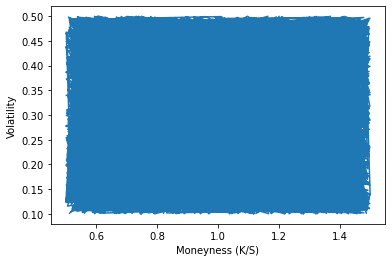

In [609]:
plt.plot(Ms, Vs);
plt.xlabel("Moneyness (K/S)")
plt.ylabel("Volatility");

### 3.2. Data Visualization

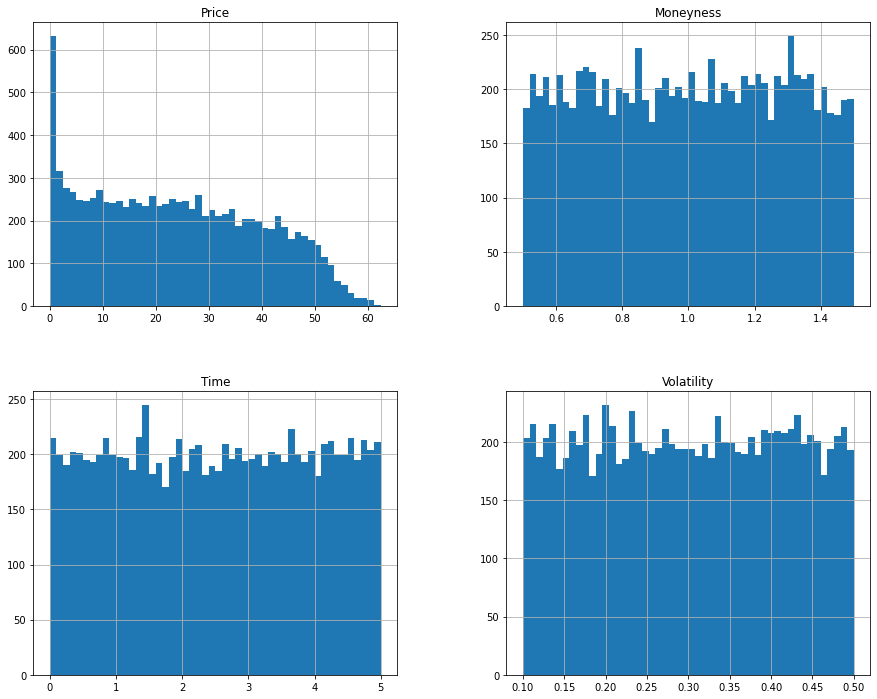

In [610]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=10, ylabelsize=10, figsize=(15,12));

We can see that the price has an interesting distribution with a spike at $0$ due to all of the OTM options. Strike is Gaussian distributed around 100 and the time is uniformally distributed out to 5 years

Next we look at the interaction between different variables

In [611]:
X.shape[1:]

(3,)

In [612]:
Y.shape

(10000,)

We see some very interesting non linear analysis. This means that we expect our non linear models to do a better job than our linear models.

### 3.3 Feature Importance Analysis

In [613]:
bestfeatures = SelectKBest(k='all', score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(['Strike', 'Time', 'Volatility'])
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
Strike,21406.854
Time,1456.789
Volatility,1154.505


## 4. Evaluating Models and Parameters

### 4.1. Train Test Split

In [614]:
dataset

,Price,Moneyness,Time,Volatility
0,25.258,0.961,4.347,0.242
1,12.944,1.417,1.444,0.500
2,27.480,0.763,1.427,0.230
3,30.444,0.763,3.148,0.181
4,8.362,1.372,3.663,0.222
...,...,...,...,...
9995,31.403,0.686,0.028,0.137
9996,9.231,1.267,1.222,0.384
9997,45.393,0.921,4.475,0.499
9998,33.897,0.956,4.048,0.374


In [615]:
X_train, X_test, y_train, y_test = train_test_split(dataset.iloc[:,1:], 
                                                              dataset.iloc[:,0],
                                                              random_state=42)

In [616]:
y_test

6252   13.065
4684   32.448
1731    1.046
4742   22.156
4521   14.260
        ...  
4862   54.760
7025    3.102
7647    2.019
7161   43.143
73     22.521
Name: Price, Length: 2500, dtype: float64

In [617]:
X_test.applymap('{:,.6f}'.format)

,Moneyness,Time,Volatility
6252,0.889764,0.124362,0.436671
4684,1.292209,4.687661,0.450858
1731,1.412684,3.070510,0.121871
4742,0.809404,0.485994,0.359354
4521,1.042650,1.326768,0.326167
...,...,...,...
4862,0.528261,2.633653,0.460869
7025,1.205024,0.771549,0.254596
7647,1.411851,3.449895,0.136203
7161,0.693156,4.388640,0.298818


In [618]:
call_option_price(100, 0.864916, 2.038090, 0.111280)

17.824534550839928

In [619]:
X_train.shape

(7500, 3)

In [620]:
#scaler = StandardScaler()
#X = scaler.fit_transform(X)
#X_test = scaler.transform(X_test)
#X_train = scaler.transform(X_train)

In [621]:
r = 0.02
s0 = 100.0

def option_vol(m):
    a = 0.35
    b = -0.1
    c = 0.02
    vol = a + b*m + c*m*m
    return vol

moneyness = np.linspace(0.5, 2.0, 100)
v = option_vol(moneyness)

N = 10000

Ms_ = (0.5+1.0*np.random.random(N))
Ts_ = np.random.random(N) * 5.0
Vs_ = option_vol(Ms)
Ps_ = np.array([call_option_price(s0, m, t, v) for m, t, v in zip(Ms_,Ts_,Vs_)])

Y_ = Ps

X_ = np.concatenate([Ms.reshape(-1,1), Ts.reshape(-1,1), Vs.reshape(-1,1)], axis=1)

dataset = pd.DataFrame(np.concatenate([Y.reshape(-1,1), X], axis=1),
                       columns=['Price', 'Moneyness', 'Time', 'Volatility'])

validation_size = 0.2

train_size = int(len(X_) * (1-validation_size))
X_train_, X_test_ = X_[0:train_size], X_[train_size:len(X_)]
Y_train_, Y_test_ = Y_[0:train_size], Y_[train_size:len(X_)]

scoring = 'neg_mean_squared_error' 

from sklearn.neural_network import MLPRegressor

model = MLPRegressor()

In [622]:
res = model.fit(X_train, y_train)
train_result = mean_squared_error(res.predict(X_train), y_train)
train_result

3.4342124817523785

In [623]:
test_result = mean_squared_error(res.predict(X_test), y_test)
test_result

3.471703724820496

In [624]:

predictions = res.predict(X)
mean_squared_error(Y, predictions)

3.443585292519408

In [625]:
X

array([[0.96103142, 4.34696511, 0.24202328],
       [1.41686207, 1.44428914, 0.49968926],
       [0.76315304, 1.42679291, 0.22977796],
       ...,
       [0.92119436, 4.47488723, 0.49903877],
       [0.95604084, 4.04831935, 0.37432076],
       [0.88159158, 1.11558023, 0.39239705]])

In [626]:
X_test

,Moneyness,Time,Volatility
6252,0.890,0.124,0.437
4684,1.292,4.688,0.451
1731,1.413,3.071,0.122
4742,0.809,0.486,0.359
4521,1.043,1.327,0.326
...,...,...,...
4862,0.528,2.634,0.461
7025,1.205,0.772,0.255
7647,1.412,3.450,0.136
7161,0.693,4.389,0.299


In [627]:
s0 = 100.0
strike = np.linspace(0.7*s0, 1.3*s0, 100)
moneyness = strike / s0
time_to_maturity = np.ones(100)*1
option_vol_vector = option_vol(moneyness)

np.array([moneyness, time_to_maturity, option_vol_vector]).transpose()

array([[0.7       , 1.        , 0.2898    ],
       [0.70606061, 1.        , 0.28936437],
       [0.71212121, 1.        , 0.28893021],
       [0.71818182, 1.        , 0.28849752],
       [0.72424242, 1.        , 0.2880663 ],
       [0.73030303, 1.        , 0.28763655],
       [0.73636364, 1.        , 0.28720826],
       [0.74242424, 1.        , 0.28678145],
       [0.74848485, 1.        , 0.28635611],
       [0.75454545, 1.        , 0.28593223],
       [0.76060606, 1.        , 0.28550983],
       [0.76666667, 1.        , 0.28508889],
       [0.77272727, 1.        , 0.28466942],
       [0.77878788, 1.        , 0.28425142],
       [0.78484848, 1.        , 0.28383489],
       [0.79090909, 1.        , 0.28341983],
       [0.7969697 , 1.        , 0.28300624],
       [0.8030303 , 1.        , 0.28259412],
       [0.80909091, 1.        , 0.28218347],
       [0.81515152, 1.        , 0.28177429],
       [0.82121212, 1.        , 0.28136657],
       [0.82727273, 1.        , 0.28096033],
       [0.

In [635]:
def plot_fit(tmat):

    s0 = 100.0
    strike = np.linspace(0.7*s0, 1.3*s0, 100)
    moneyness = strike / s0
    time_to_maturity = np.ones(100)*tmat
    option_vol_vector = option_vol(moneyness)

    bs_price = call_option_price(s0, moneyness, time_to_maturity, option_vol_vector)

    X_ = np.array([moneyness, time_to_maturity, option_vol_vector]).transpose()
    #X_ = scaler.transform(X_)
    predicted_price = res.predict(X_)

    plt.plot(strike, bs_price, label='Black Scholes')
    plt.plot(strike, predicted_price, label='Predicted Price')
    plt.xlabel("Strike")
    plt.ylabel("Call Option Value")
    plt.title("Expiry in " + str(tmat) + " yea")
    plt.legend();

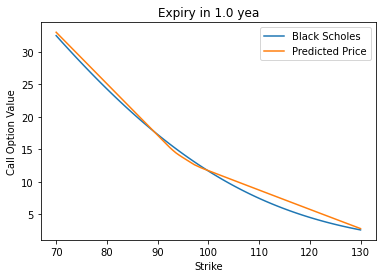

In [636]:
plot_fit(1.00)

In [637]:
def plot_fit(tmat):

    s0 = 100.0
    strike = np.linspace(0.7*s0, 1.3*s0, 100)
    moneyness = strike / s0
    time_to_maturity = np.ones(100)*tmat
    option_vol_vector = option_vol(moneyness)

    bs_price = call_option_price(s0, moneyness, time_to_maturity, option_vol_vector)

    X_ = np.array([moneyness, time_to_maturity, option_vol_vector]).transpose()
    #X_ = scaler.transform(X_)
    predicted_price = res.predict(X_)

    plt.plot(strike, bs_price, label='Black Scholes')
    plt.plot(strike, predicted_price, label='Predicted Price')
    plt.xlabel("Strike")
    plt.ylabel("Call Option Value")
    plt.title("Expiry in " + str(tmat) + " yea")
    plt.legend();

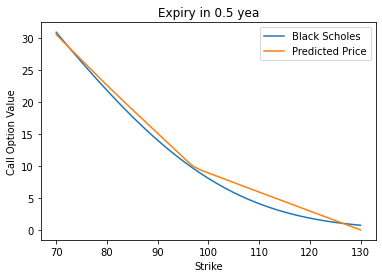

In [638]:
plot_fit(0.50)

### 4.2. Setting up a Neural Network model using Keras

We setup the first NN with the following attributes:

* 3 input layers - one for each feature
* 3 hidden layers with 50 nodes each and relu activation
* A dropout layer with 20% dropout probability after each hidden layer
* One output layer with linear activation for linear regression
* 40 epochs
* Minimium Squared Error as loss function
* ADAM as default optimizer

In [639]:
# Setting up a training function
learning_rate=0.001
optimizer = tf.keras.optimizers.Adam(learning_rate)

def train_model(hidden_layers, nodes, optimizer=optimizer):
    model = Sequential()
    
    
    model.add(Input(shape=X_train.shape[1:]))

    for x in range(0, hidden_layers):
        model.add(Dense(nodes, activation='relu'))
        #model.add(Dropout(0.20))
    
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer = optimizer)
    
    return model

In [640]:
# Model summary
train_model(hidden_layers=1, nodes=100).summary()

Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_244 (Dense)           (None, 100)               400       
                                                                 
 dense_245 (Dense)           (None, 1)                 101       
                                                                 
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________


In [641]:
len(X_train)

7500

In [642]:
# Fitting the model using earlystopping

g = train_model(hidden_layers=1, nodes=100).fit(X_train, y_train, epochs=100, batch_size=200, validation_data=(X_test, y_test))

Epoch 1/100
38/38 [==============================] - 1s 7ms/step - loss: 797.3283 - val_loss: 746.1957
Epoch 2/100
38/38 [==============================] - 0s 4ms/step - loss: 704.7094 - val_loss: 639.8218
Epoch 3/100
38/38 [==============================] - 0s 4ms/step - loss: 578.1901 - val_loss: 500.9789
Epoch 4/100
38/38 [==============================] - 0s 4ms/step - loss: 435.9954 - val_loss: 370.1257
Epoch 5/100
38/38 [==============================] - 0s 4ms/step - loss: 324.7245 - val_loss: 290.6938
Epoch 6/100
38/38 [==============================] - 0s 3ms/step - loss: 268.8154 - val_loss: 259.6931
Epoch 7/100
38/38 [==============================] - 0s 4ms/step - loss: 249.5844 - val_loss: 248.3004
Epoch 8/100
38/38 [==============================] - 0s 4ms/step - loss: 240.6376 - val_loss: 240.3312
Epoch 9/100
38/38 [==============================] - 0s 4ms/step - loss: 232.6266 - val_loss: 231.7066
Epoch 10/100
38/38 [==============================] - 0s 3ms/step - loss:

In [643]:
final_loss_adam = g.history['loss'][-1]
final_val_loss_adam = g.history['val_loss'][-1]

In [644]:
final_val_loss_adam

21.154495239257812

### 4.3. Evaluating Results

First, we look at the Loss x Epochs graphic to analyse the efficiency gain in our model

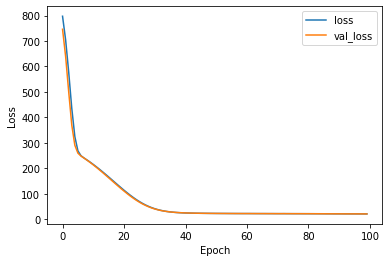

In [645]:
plt.plot(g.history['loss'], label='loss')
plt.plot(g.history['val_loss'], label='val_loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend();

Now, we create a Predicted x Actual price graph to have a visual on how well is our model predicting the label

In [646]:
g.model.predict(X)

array([[29.997955],
       [ 9.665847],
       [27.227835],
       ...,
       [43.783012],
       [34.926414],
       [27.65675 ]], dtype=float32)

In [647]:
g.model(X)
#predicted_price = g.model.predict(X)

<tf.Tensor: shape=(10000, 1), dtype=float32, numpy=
array([[29.997955],
       [ 9.665847],
       [27.227835],
       ...,
       [43.783012],
       [34.926414],
       [27.65675 ]], dtype=float32)>

In [648]:
Y

array([25.25769582, 12.94439392, 27.47977846, ..., 45.39310363,
       33.89707585, 23.13087616])

In [649]:
X

array([[0.96103142, 4.34696511, 0.24202328],
       [1.41686207, 1.44428914, 0.49968926],
       [0.76315304, 1.42679291, 0.22977796],
       ...,
       [0.92119436, 4.47488723, 0.49903877],
       [0.95604084, 4.04831935, 0.37432076],
       [0.88159158, 1.11558023, 0.39239705]])

In [650]:
call_option_price(100, 1.27770241, 1.78996949, 0.2247701)

4.773460358673336

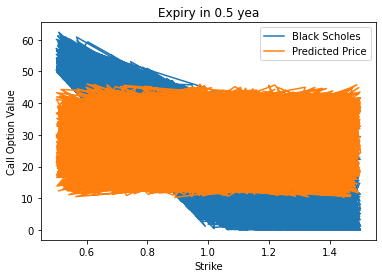

In [651]:
plt.plot(Ms, Y, label='Black Scholes')
plt.plot(Ms, predicted_price, label='Predicted Price')
plt.xlabel("Strike")
plt.ylabel("Call Option Value")
plt.title("Expiry in " + str(0.5) + " yea")
plt.legend()

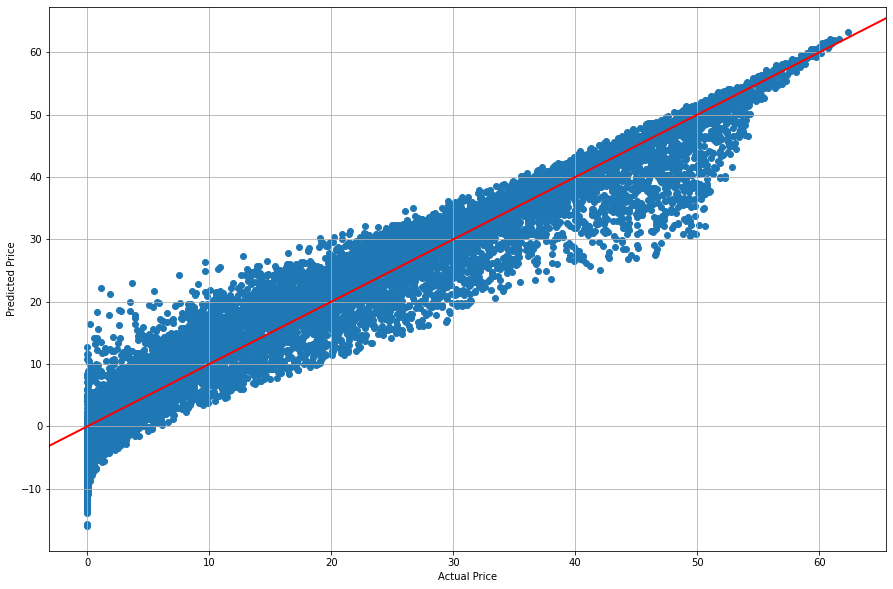

In [652]:
predictions = g.model.predict(X)
plt.figure(figsize = (15,10))
plt.scatter(Y, predictions)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.axline((15,15), (18, 18), linewidth=2, color='r')
plt.grid(True)

In [653]:
final_val_loss_adam

21.154495239257812

### 4.4. Choosing best optimizer

Now, before moving on to the analysis of the neural network structure, let's see if we can get better results using Rmsprop instead of Adam

In [654]:
g_2 = train_model(hidden_layers=3, nodes=50, optimizer='rmsprop').fit(X_train, y_train, epochs=40, validation_data=(X_test, y_test))

Epoch 1/40
235/235 [==============================] - 1s 3ms/step - loss: 303.2984 - val_loss: 182.7000
Epoch 2/40
235/235 [==============================] - 0s 2ms/step - loss: 76.8279 - val_loss: 25.3332
Epoch 3/40
235/235 [==============================] - 0s 2ms/step - loss: 19.4010 - val_loss: 18.4545
Epoch 4/40
235/235 [==============================] - 0s 2ms/step - loss: 16.7068 - val_loss: 14.2555
Epoch 5/40
235/235 [==============================] - 0s 2ms/step - loss: 14.9681 - val_loss: 12.5083
Epoch 6/40
235/235 [==============================] - 0s 2ms/step - loss: 13.3005 - val_loss: 10.9973
Epoch 7/40
235/235 [==============================] - 0s 2ms/step - loss: 11.1329 - val_loss: 12.1400
Epoch 8/40
235/235 [==============================] - 0s 2ms/step - loss: 8.6677 - val_loss: 6.8584
Epoch 9/40
235/235 [==============================] - 0s 2ms/step - loss: 6.4361 - val_loss: 4.2716
Epoch 10/40
235/235 [==============================] - 0s 2ms/step - loss: 4.5379 - 

In [655]:
final_loss_rms = g_2.history['loss'][-1]
final_val_loss_rms = g_2.history['val_loss'][-1]

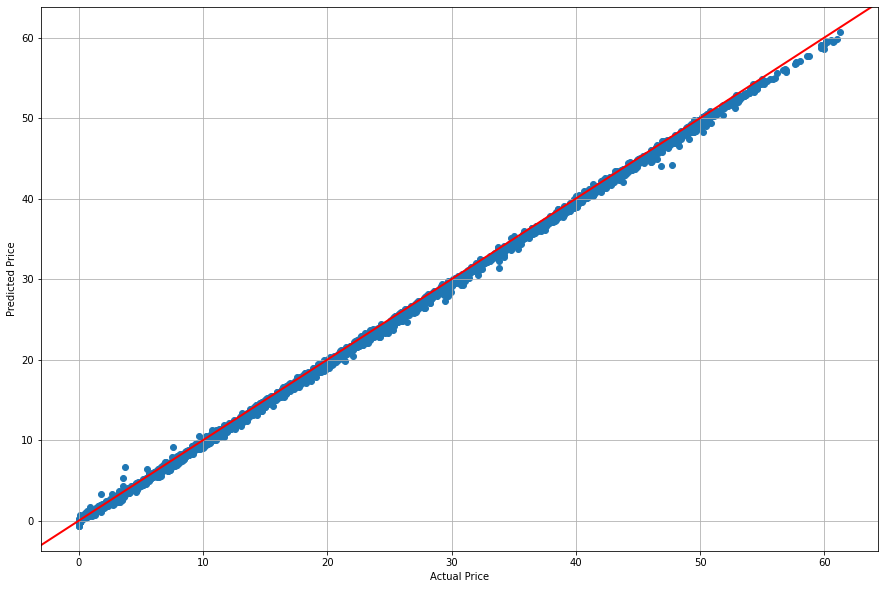

In [656]:
predictions_2 = g_2.model.predict(X_test)
plt.figure(figsize = (15,10))
plt.scatter(y_test, predictions_2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.axline((16,16), (18, 18), linewidth=2, color='r')
plt.grid(True)

In [657]:
opt_compare = pd.DataFrame(data=[[final_val_loss_adam, final_val_loss_rms]], columns = ['Adam', 'RmsProp'])
opt_compare

,Adam,RmsProp
0,21.154,0.361


We can observe that the final loss using RmsProp is slightly better, and the Prediction x Actual graph using RmsProp also looks better, so we will stick to that optimizer from now on

### 4.5. Analysing Neural Network structure

To better understand and find the most adequate Neural Network structure for this model, we will retrain it with varying values for hidden layers and number of neurons per layer. We'll be using the following parameters:

* Inputs:
    * Hidden layers: array [1,2,3,4]
    * Neurons: [10,20,50,100]


* Outputs:
    * 16 different NN models, containing:
        * Final loss
        * Final val loss

First, we loop through the inputs and store the results in a dataframe:

In [660]:
results_df = pd.DataFrame(columns=['Hidden layers', 'Nodes', 'Val Loss'])

for i in [1, 2, 3, 4]:
    for x in [10, 20, 50, 100]:
        nn = train_model(hidden_layers=i, nodes = x, optimizer=optimizer).fit(X_train, y_train, epochs=100, batch_size = 200, verbose=1, validation_data=(X_test, y_test))
        L = [i, x, nn.history['val_loss'][-1]]
        results_df.loc[len(results_df)] = L

Epoch 1/100
38/38 [==============================] - 0s 5ms/step - loss: 742.0248 - val_loss: 662.2153
Epoch 2/100
38/38 [==============================] - 0s 2ms/step - loss: 585.1356 - val_loss: 499.1334
Epoch 3/100
38/38 [==============================] - 0s 2ms/step - loss: 439.0563 - val_loss: 381.6015
Epoch 4/100
38/38 [==============================] - 0s 2ms/step - loss: 342.6933 - val_loss: 310.9821
Epoch 5/100
38/38 [==============================] - 0s 4ms/step - loss: 288.7993 - val_loss: 274.1824
Epoch 6/100
38/38 [==============================] - 0s 3ms/step - loss: 261.2323 - val_loss: 256.0581
Epoch 7/100
38/38 [==============================] - 0s 3ms/step - loss: 247.3824 - val_loss: 246.3061
Epoch 8/100
38/38 [==============================] - 0s 3ms/step - loss: 239.2263 - val_loss: 239.4902
Epoch 9/100
38/38 [==============================] - 0s 3ms/step - loss: 233.0313 - val_loss: 233.4374
Epoch 10/100
38/38 [==============================] - 0s 3ms/step - loss:

In [661]:
results_df

,Hidden layers,Nodes,Val Loss
0,1.000,10.000,23.225
1,1.000,20.000,22.537
2,1.000,50.000,12.446
3,1.000,100.000,8.262
4,2.000,10.000,13.918
5,2.000,20.000,0.674
6,2.000,50.000,0.373
7,2.000,100.000,0.084
8,3.000,10.000,1.652
9,3.000,20.000,0.847


Now we find the architechture with the least Loss value

In [662]:
best_arch = results_df.sort_values('Val Loss').iloc[0]
best_arch

Hidden layers     4.000
Nodes           100.000
Val Loss          0.037
Name: 15, dtype: float64

Let's take a look at the Predicted x Actual Graph with this new architechture

In [663]:
nn = train_model(hidden_layers=4, nodes = 100, optimizer=optimizer).fit(X_train, y_train, epochs=100, batch_size = 200, validation_data=(X_test, y_test))

Epoch 1/100
38/38 [==============================] - 1s 7ms/step - loss: 329.2651 - val_loss: 183.3918
Epoch 2/100
38/38 [==============================] - 0s 4ms/step - loss: 71.5138 - val_loss: 19.7234
Epoch 3/100
38/38 [==============================] - 0s 4ms/step - loss: 17.1347 - val_loss: 15.5315
Epoch 4/100
38/38 [==============================] - 0s 4ms/step - loss: 13.9530 - val_loss: 12.5329
Epoch 5/100
38/38 [==============================] - 0s 4ms/step - loss: 12.1698 - val_loss: 10.6634
Epoch 6/100
38/38 [==============================] - 0s 4ms/step - loss: 9.6248 - val_loss: 8.8273
Epoch 7/100
38/38 [==============================] - 0s 4ms/step - loss: 7.0472 - val_loss: 5.2564
Epoch 8/100
38/38 [==============================] - 0s 4ms/step - loss: 3.5727 - val_loss: 2.5284
Epoch 9/100
38/38 [==============================] - 0s 4ms/step - loss: 1.5252 - val_loss: 0.8514
Epoch 10/100
38/38 [==============================] - 0s 4ms/step - loss: 0.7082 - val_loss: 0.47

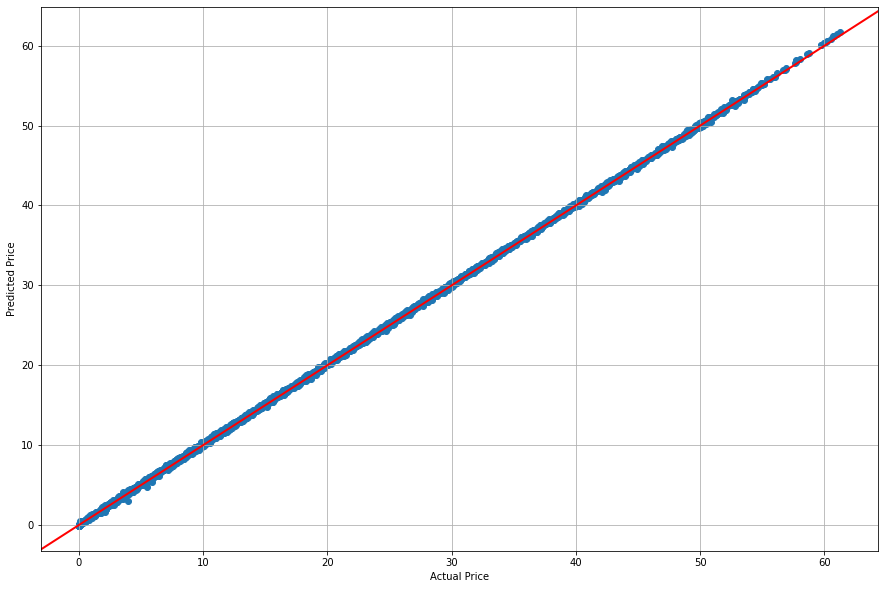

In [665]:
predictions_2 = nn.model.predict(X_test)
plt.figure(figsize = (15,10))
plt.scatter(y_test, predictions_2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.axline((0,0), (17.5, 17.5), linewidth=2, color='r')
plt.grid(True)

## 5. Calculating and Analysing delta

For this part of the question, we will firt calculate Delta using the Black-Scholes equation in the training and test examples.

$$\Delta C=\mathrm{e}^{-qt}N(d1)$$

In [666]:
# Defining the call_delta function
def call_delta(M, t, v, q):
    # Black Scholes Equation
    d1=(-np.log(M)+(r+np.square(v)/2)*t)/(v*np.sqrt(t))
    N_d1 = norm.cdf(d1)
    return np.exp(-q*t) * N_d1

In [667]:
# Testing the new function
call_delta(0.79906977, 3.76447894, 0.2489582, 0)

0.805588857405409

In [668]:
delta_BS = np.array([call_delta(M, t, v, 0) for M, t, v in zip(Ms,Ts,Vs)])

In [669]:
delta_BS

array([0.69264622, 0.40831654, 0.88990262, ..., 0.75501808, 0.70669923,
       0.71401036])

In [670]:
len(delta_BS.reshape(-1,1))

10000

Now, we will calculate Delta using our trained network. To do this, we will calculate the new call price P' considering a 0.01 variation in stock price, which is equivalent to a 0.0001 variation in moneyness (S0=100, Strike=100). With that value we are able to calculate Delta by applying:

$$\Delta C=(P'-P) / 0.01$$

In [671]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [672]:
X_test_new = pd.DataFrame(X_test, columns=['Moneyness','Time','Volatility']).copy()
1/((1/X_test_new['Moneyness'])+0.0001)

6252   0.88968
4684   1.29204
1731   1.41248
4742   0.80934
4521   1.04254
         ...  
4862   0.52823
7025   1.20488
7647   1.41165
7161   0.69311
73     1.18413
Name: Moneyness, Length: 2500, dtype: float64

In [673]:
dataset

,Price,Moneyness,Time,Volatility
0,25.25770,0.96103,4.34697,0.24202
1,12.94439,1.41686,1.44429,0.49969
2,27.47978,0.76315,1.42679,0.22978
3,30.44427,0.76307,3.14752,0.18123
4,8.36164,1.37192,3.66294,0.22190
...,...,...,...,...
9995,31.40316,0.68636,0.02844,0.13721
9996,9.23125,1.26713,1.22194,0.38409
9997,45.39310,0.92119,4.47489,0.49904
9998,33.89708,0.95604,4.04832,0.37432


In [674]:
dataset_new = pd.DataFrame(dataset, columns=['Moneyness','Time','Volatility'])
Ms2=1/((1/Ms)+0.0001)
X_new = np.concatenate([Ms2.reshape(-1,1), Ts2.reshape(-1,1),Vs2.reshape(-1,1)],axis=1)
#X_new = scaler.transform(X_new)
Ps2 = np.array([call_option_price(s0, m, t, v) for m, t, v in zip(Ms2,Ts2,Vs2)])
dataset_new = pd.DataFrame(data=np.concatenate((Ps2.reshape(-1,1),X_new),axis=1), columns=['Price,','Moneyness','Time','Volatility'])
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(dataset_new.iloc[:,1:], 
                                                              dataset_new.iloc[:,0],
                                                              random_state=42)

In [579]:
## retraining the model with the the new sample
nn2 = train_model(hidden_layers=3, nodes = 100, optimizer=optimizer).fit(X_train_new, y_train_new, epochs=100, batch_size=200, validation_data=(X_test_new, y_test_new))

Epoch 1/100
38/38 [==============================] - 1s 7ms/step - loss: 235.3304 - val_loss: 19.1281
Epoch 2/100
38/38 [==============================] - 0s 4ms/step - loss: 10.9766 - val_loss: 7.3046
Epoch 3/100
38/38 [==============================] - 0s 4ms/step - loss: 5.6931 - val_loss: 4.4231
Epoch 4/100
38/38 [==============================] - 0s 4ms/step - loss: 3.2195 - val_loss: 2.2980
Epoch 5/100
38/38 [==============================] - 0s 4ms/step - loss: 1.7795 - val_loss: 1.4527
Epoch 6/100
38/38 [==============================] - 0s 4ms/step - loss: 1.2665 - val_loss: 1.1182
Epoch 7/100
38/38 [==============================] - 0s 5ms/step - loss: 0.9900 - val_loss: 0.9200
Epoch 8/100
38/38 [==============================] - 0s 4ms/step - loss: 0.7931 - val_loss: 0.7282
Epoch 9/100
38/38 [==============================] - 0s 4ms/step - loss: 0.6494 - val_loss: 0.6259
Epoch 10/100
38/38 [==============================] - 0s 4ms/step - loss: 0.5361 - val_loss: 0.4774
Epoch

In [675]:
yhat_1_IS = nn.model.predict(X_train)
yhat_1_OS = nn.model.predict(X_test)

yhat_2_IS = nn.model.predict(X_train_new)
yhat_2_OS = nn.model.predict(X_test_new)

In [677]:
yhat_2_IS

array([[22.535097],
       [17.997328],
       [ 4.881493],
       ...,
       [50.379185],
       [22.37586 ],
       [19.534613]], dtype=float32)

In [678]:
y_train.max()

62.381895720095365

In [679]:
y_train_new.max()

62.38328504277468

In [680]:
yhat_1_IS

array([[22.528801 ],
       [17.99251  ],
       [ 4.8775277],
       ...,
       [50.376842 ],
       [22.3711   ],
       [19.53095  ]], dtype=float32)

In [681]:
delta_1_IS = (yhat_2_IS - yhat_1_IS) / 0.01
delta_1_OS = (yhat_2_OS - yhat_1_OS) / 0.01

delta_2_IS = (np.array(y_train_new) - np.array(y_train)) / 0.01
delta_2_OS = (np.array(y_test_new) - np.array(y_test)) / 0.01

In [682]:
np.array(y_train_new)

array([22.65734399, 17.80937261,  4.7138976 , ..., 50.27718718,
       22.34128311, 19.27201688])

In [683]:
np.array(y_train)

array([22.65136156, 17.80502989,  4.71040629, ..., 50.27491352,
       22.33596744, 19.26787339])

In [684]:
delta_1_IS

array([[0.6296158 ],
       [0.48179626],
       [0.39653778],
       ...,
       [0.23422241],
       [0.47607422],
       [0.36621094]], dtype=float32)

In [685]:
comparison = pd.DataFrame(yhat_2_IS.reshape(-1,1))
comparison[1] = pd.DataFrame(yhat_1_IS.reshape(-1,1))
comparison[2] = pd.DataFrame(delta_1_IS.reshape(-1,1))
comparison[3] = pd.DataFrame(np.array(y_train_new).reshape(-1,1))
comparison[4] = pd.DataFrame(np.array(y_train).reshape(-1,1))
comparison[5] = pd.DataFrame(delta_2_IS.reshape(-1,1))
comparison[6] = comparison[0] -comparison[3]
comparison[7] = comparison[1] -comparison[4]
comparison[8] = comparison[2] -comparison[5]

comparison

,0,1,2,3,4,5,6,7,8
0,22.53510,22.52880,0.62962,22.65734,22.65136,0.59824,-0.12225,-0.12256,0.03137
1,17.99733,17.99251,0.48180,17.80937,17.80503,0.43427,0.18796,0.18748,0.04752
2,4.88149,4.87753,0.39654,4.71390,4.71041,0.34913,0.16760,0.16712,0.04741
3,29.76960,29.76560,0.39940,29.41904,29.41525,0.37901,0.35056,0.35036,0.02039
4,26.47220,26.46861,0.35877,26.55674,26.55261,0.41297,-0.08454,-0.08399,-0.05419
...,...,...,...,...,...,...,...,...,...
7495,14.89251,14.88855,0.39530,14.75820,14.75401,0.41942,0.13430,0.13454,-0.02412
7496,45.68652,45.68373,0.27885,46.00379,46.00097,0.28243,-0.31728,-0.31724,-0.00358
7497,50.37918,50.37684,0.23422,50.27719,50.27491,0.22737,0.10200,0.10193,0.00686
7498,22.37586,22.37110,0.47607,22.34128,22.33597,0.53157,0.03458,0.03513,-0.05549


In [686]:
(comparison[5]+comparison[8]).mean()

0.35824273904164633

In [597]:
comparison=pd.DataFrame(data={pd.DataFrame(yhat_2_IS),pd.DataFrame(yhat_1_IS),pd.DataFrame(delta_1_IS),pd.DataFrame(np.array(y_train_new)), pd.DataFrame(np.array(y_train)),pd.DataFrame(delta_2_IS)})
comparison

TypeError: unhashable type: 'DataFrame'

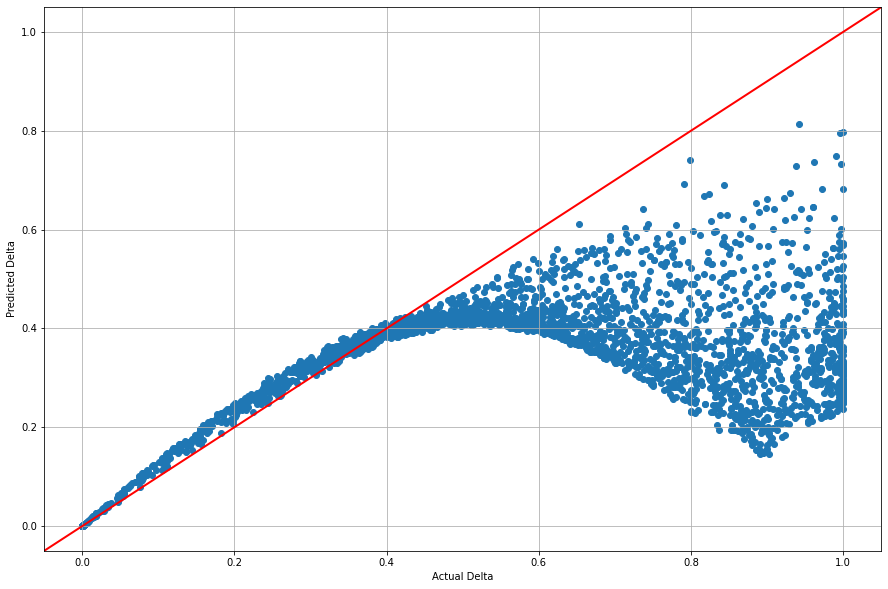

In [705]:
Ms_d=dataset.iloc[y_test.index,:]['Moneyness']
Ts_d=dataset.iloc[y_test.index,:]['Time']
Vs_d=dataset.iloc[y_test.index,:]['Volatility']
delta_BS = np.array([call_delta(M, t, v, 0) for M, t, v in zip(Ms_d,Ts_d,Vs_d)])
plt.figure(figsize = (15,10))
plt.scatter(delta_BS,delta_2_OS)
plt.xlabel("Actual Delta")
plt.ylabel("Predicted Delta")
plt.axline((0,0), (1, 1), linewidth=2, color='r')
plt.grid(True)

In [706]:
Ts.min()

0.00021702136936974092

In [701]:
dataset.iloc[y_test.index,:]

,Price,Moneyness,Time,Volatility
6252,13.06477,0.88976,0.12436,0.43667
4684,32.44769,1.29221,4.68766,0.45086
1731,1.04628,1.41268,3.07051,0.12187
4742,22.15560,0.80940,0.48599,0.35935
4521,14.25962,1.04265,1.32677,0.32617
...,...,...,...,...
4862,54.76037,0.52826,2.63365,0.46087
7025,3.10222,1.20502,0.77155,0.25460
7647,2.01944,1.41185,3.44989,0.13620
7161,43.14315,0.69316,4.38864,0.29882


In [698]:
np.sort(y_test.index)

array([   0,    3,    8, ..., 9989, 9993, 9998], dtype=int64)

In [510]:
delta_1_IS

array([[-3699.2588  ],
       [-2805.0725  ],
       [   87.386024],
       ...,
       [-1749.5884  ],
       [-1235.472   ],
       [-4546.574   ]], dtype=float32)

In [511]:
delta_2_OS

array([-5632.84194362,  -372.10892584,  -323.56122486, ...,
       -1625.86211636, -1001.55997052, -2023.24367616])

In [512]:
delta_1_OS

array([[-5608.0513 ],
       [ -377.38123],
       [ -334.2017 ],
       ...,
       [-1648.2583 ],
       [ -991.28546],
       [-2021.1504 ]], dtype=float32)

In [513]:
predictions_2

array([[56.82561  ],
       [ 5.065892 ],
       [ 4.6945376],
       ...,
       [17.68497  ],
       [11.136608 ],
       [21.245487 ]], dtype=float32)

In [514]:
yhat_1_OS

array([[56.82561  ],
       [ 5.065892 ],
       [ 4.6945376],
       ...,
       [17.68497  ],
       [11.136608 ],
       [21.245487 ]], dtype=float32)

In [515]:
yhat_2_OS

array([[0.7451018],
       [1.2920798],
       [1.352521 ],
       ...,
       [1.2023886],
       [1.2237538],
       [1.0339826]], dtype=float32)

In [516]:
y_train

4901   37.99601
4375   29.22522
6698    0.57566
9805    8.28217
1101   20.49430
         ...   
5734   34.70040
5191   16.40876
5390   18.56477
860    13.55235
7270   46.07004
Name: Price, Length: 7500, dtype: float64

In [517]:
y_train_new

4901   0.93620
4375   0.97816
6698   1.44578
9805   1.45354
1101   1.03300
         ...  
5734   0.66820
5191   0.98110
5390   0.89902
860    1.08164
7270   0.54453
Name: Moneyness, Length: 7500, dtype: float64

In [518]:
Ms2=1/((1/Ms)+0.0001)
Ps2 = np.array([call_option_price(100.01, m, t, v) for m, t, v in zip(Ms2,Ts2,Vs2)])

In [519]:
# We start by replicating the full sample X, altering just the moneyness
#Vs2 = np.array([dataset['Volatility']]).copy()
#Ts2 = np.array([dataset['Time']]).copy()
#Ms2 = np.array([dataset['Moneyness']]).copy() # We add 0.0001 to the moneyness column (equivalent to adding 0.01 to price)

X2 = np.concatenate([Ms2.reshape(-1,1), Ts2.reshape(-1,1), Vs2.reshape(-1,1)], axis=1)

In [520]:
X2

array([[0.51060053, 2.74059924, 0.4899807 ],
       [1.48308871, 0.84187083, 0.45314065],
       [1.17828446, 0.57221773, 0.18022272],
       ...,
       [0.67801383, 2.4105049 , 0.17197767],
       [1.48328945, 2.40986015, 0.40171593],
       [1.44347875, 3.04493847, 0.31217342]])

In [521]:
X

array([[-1.70900424,  0.18442306,  1.6559905 ],
       [ 1.67138516, -1.13221031,  1.33645147],
       [ 0.61180843, -1.31919559, -1.03075278],
       ...,
       [-1.12711892, -0.04447394, -1.10226773],
       [ 1.672083  , -0.04492103,  0.89040961],
       [ 1.53368726,  0.39546071,  0.11374611]])

In [522]:
# Now we define the predicted Call Prices before and after the stock price alteration using our previously defined model
pred_prices = nn.model.predict(X)
pred_prices_2 = nn.model.predict(X2)

In [523]:
pred_prices_2

array([[35.854588],
       [16.831612],
       [14.886595],
       ...,
       [29.344593],
       [25.316854],
       [28.436996]], dtype=float32)

In [524]:
pred_prices

array([[57.117023 ],
       [ 4.7447996],
       [ 1.0074455],
       ...,
       [35.677464 ],
       [12.917942 ],
       [11.294043 ]], dtype=float32)

In [525]:
Ps

array([57.08557497,  4.90571371,  0.96833108, ..., 35.84079593,
       13.10487784, 11.16032867])

In [526]:
Ps2

array([57.0929822 ,  4.90906677,  0.97003973, ..., 35.84846997,
       13.110236  , 11.16540577])

In [527]:
delta_NN = (pred_prices_2-Y)/0.01
delta_NN

array([[-2.12309874e+03,  3.09488738e+03,  3.48862565e+03, ...,
         1.37916277e+00,  2.27497097e+03,  2.46942589e+03],
       [-4.02539633e+03,  1.19258979e+03,  1.58632806e+03, ...,
        -1.90091843e+03,  3.72673379e+02,  5.67128296e+02],
       [-4.21989802e+03,  9.98088106e+02,  1.39182637e+03, ...,
        -2.09542012e+03,  1.78171693e+02,  3.72626610e+02],
       ...,
       [-2.77409819e+03,  2.44388793e+03,  2.83762620e+03, ...,
        -6.49620288e+02,  1.62397152e+03,  1.81842644e+03],
       [-3.17687205e+03,  2.04111408e+03,  2.43485234e+03, ...,
        -1.05239415e+03,  1.22119766e+03,  1.41565258e+03],
       [-2.86485785e+03,  2.35312827e+03,  2.74686654e+03, ...,
        -7.40379947e+02,  1.53321186e+03,  1.72766678e+03]])

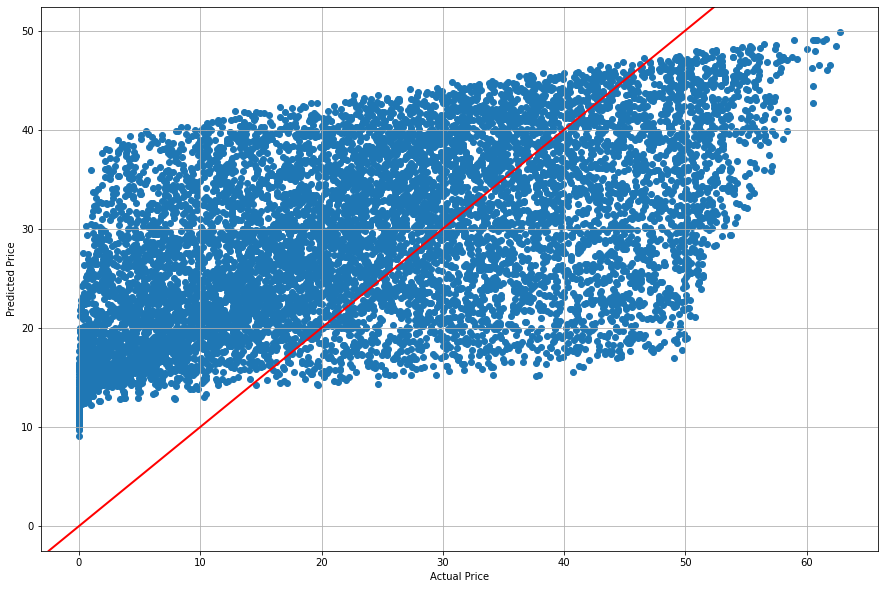

In [528]:
plt.figure(figsize = (15,10))
plt.scatter(Ps2, pred_prices_2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.axline((0,0), (17.5, 17.5), linewidth=2, color='r')
plt.grid(True)

ValueError: x and y must be the same size

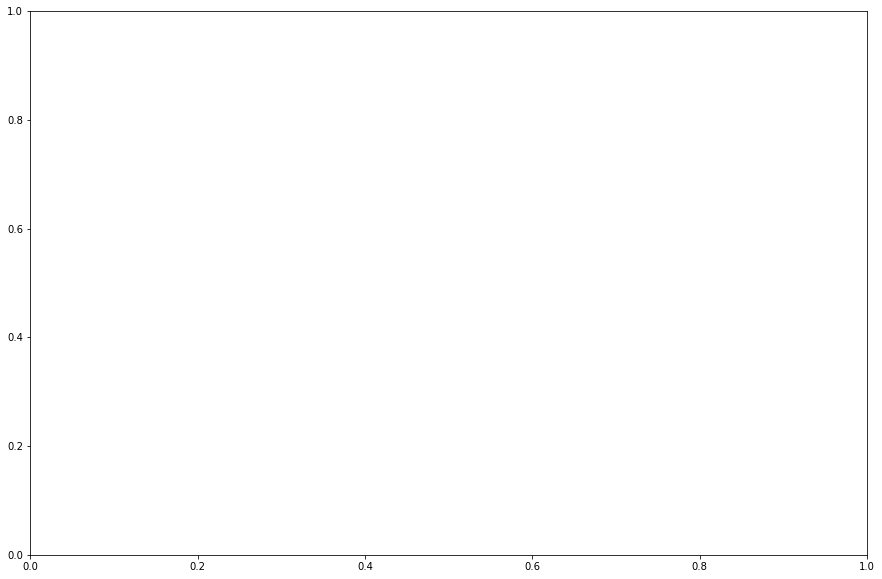

In [529]:
plt.figure(figsize = (15,10))
plt.scatter(delta_BS, delta_NN)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.axline((0,0), (1, 1), linewidth=2, color='r')
plt.grid(True)

In [194]:
delta_NN2= (Ps2-Ps)/0.01
delta_NN2

array([0.69182581, 0.77082296, 0.71371011, ..., 0.49796771, 0.74445206,
       0.67003612])

<AxesSubplot:>

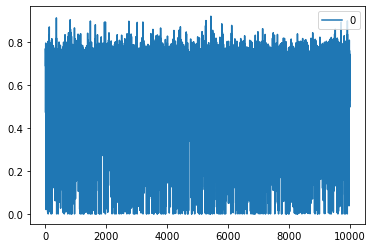

In [225]:
pd.DataFrame(delta_NN2).plot()

In [226]:
pd.DataFrame(delta_NN).plot()

<AxesSubplot:>

Error in callback <function flush_figures at 0x0000026A4953E4C0> (for post_execute):



KeyboardInterrupt



In [195]:
delta_BS

array([0.7192935 , 0.93899689, 0.86642245, ..., 0.40343637, 0.93359465,
       0.7095387 ])

In [196]:
delta_NN

array([[0.626564  ],
       [0.41732788],
       [0.27198792],
       ...,
       [0.3797531 ],
       [0.22850037],
       [0.4365921 ]], dtype=float32)

In [197]:
Ps

array([11.0115622 , 31.18872704, 44.50885385, ...,  9.75794801,
       51.24605772, 18.65338233])

In [198]:
Ps2

array([11.01848046, 31.19643527, 44.51599095, ...,  9.76292769,
       51.25350224, 18.66008269])

In [199]:
call_option_price(100,0.92437493, 2.31493874, 0.20886596)

18.65338255618996

In [200]:
call_option_price(100.01,0.92428949, 2.31493874, 0.20886596)

18.66008297379434

In [201]:
call_delta(0.92437493,2.31493874,0.20886596,0)

0.7095386936921296

In [203]:
(18.66008297379434-18.65338255618996)/0.01

0.6700417604378117

In [204]:
X

array([[0.95475286, 1.78975018, 0.12313319],
       [0.73178714, 2.53697031, 0.16067238],
       [0.63751029, 2.14004653, 0.4199464 ],
       ...,
       [1.30885469, 3.80679395, 0.21691165],
       [0.55084006, 4.05936975, 0.27404394],
       [0.92437493, 2.31493874, 0.20886596]])

In [205]:
X2

array([[0.95466172, 1.78975018, 0.12313319],
       [0.73173359, 2.53697031, 0.16067238],
       [0.63746965, 2.14004653, 0.4199464 ],
       ...,
       [1.3086834 , 3.80679395, 0.21691165],
       [0.55080972, 4.05936975, 0.27404394],
       [0.92428949, 2.31493874, 0.20886596]])

### Looking at testing error x moneyness

In [227]:
nn.history['val_loss']

[48.84494400024414,
 20.269147872924805,
 14.19338607788086,
 15.095314025878906,
 5.08803653717041,
 5.052130222320557,
 10.355712890625,
 2.045030355453491,
 1.2388001680374146,
 1.1218477487564087,
 9.064218521118164,
 0.6380130052566528,
 4.3553619384765625,
 6.124843120574951,
 1.0746656656265259,
 5.68323278427124,
 2.0615508556365967,
 5.568083763122559,
 0.3948184847831726,
 0.5900079607963562,
 2.9546306133270264,
 0.5417433977127075,
 1.231877088546753,
 0.6549367904663086,
 1.436826467514038,
 0.5125085711479187,
 4.368183612823486,
 0.4428008198738098,
 1.7352102994918823,
 1.8657948970794678,
 1.860021710395813,
 3.2681212425231934,
 0.9058099389076233,
 2.1993141174316406,
 1.216178297996521,
 0.5565041303634644,
 1.3846113681793213,
 2.844510316848755,
 5.954471588134766,
 2.374117851257324]

# Include learning rate in adam and rmsprop

# Do standarization of features